In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

**1️⃣ Load Data**

In [2]:
import kagglehub

path = kagglehub.dataset_download("aslanahmedov/walmart-sales-forecast")
print("path to dataset files: ", path)

100%|██████████| 3.36M/3.36M [00:00<00:00, 103MB/s]

Extracting files...
path to dataset files:  /root/.cache/kagglehub/datasets/aslanahmedov/walmart-sales-forecast/versions/1


In [3]:
# Load Data
features = pd.read_csv(path + "/features.csv")
stores = pd.read_csv(path + "/stores.csv")
train = pd.read_csv(path + "/train.csv")

**2️⃣ Explore the Data**

In [4]:
# Convert dates
train['Date'] = pd.to_datetime(train['Date'])
features['Date'] = pd.to_datetime(features['Date'])

In [5]:
# Merge all together
df = train.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')
df = df.merge(stores, on='Store', how='left')

In [6]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

In [8]:
df.shape

(421570, 16)

In [9]:
# Check Number of Null Values in the DataFrame
df.isna().sum()

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday,0
Temperature,0
Fuel_Price,0
MarkDown1,270889
MarkDown2,310322
MarkDown3,284479


In [10]:
# Check DataFrame for Duplicates
df.duplicated().sum()

np.int64(0)

**3️⃣ Data Cleaning**

In [11]:
# Fill missing markdowns with 0 (assuming no promotion)
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df[markdown_cols] = df[markdown_cols].fillna(0)

In [12]:
# For store-level
df_store = df.groupby(['Date', 'Store'])['Weekly_Sales'].sum().reset_index()

# For dept-level
df_dept = df.groupby(['Date', 'Dept'])['Weekly_Sales'].sum().reset_index()

In [13]:
# Handling Outliers
def detect_outliers(group):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return (group < lower) | (group > upper)

df['outlier'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(detect_outliers)

In [14]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['Type'], drop_first=True)

**4️⃣ Time Series Analysis**

In [15]:
data = df[(df['Store'] == 1) & (df['Dept'] == 1)]
data = data.sort_values('Date')

In [16]:
# Set the Date as Index
data.set_index('Date', inplace=True)
ts = data['Weekly_Sales']

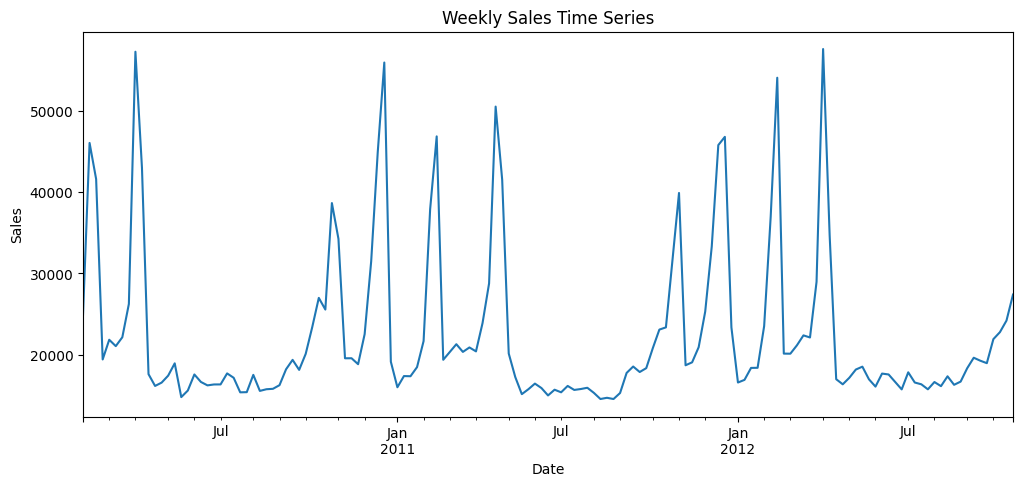

In [17]:
# Visualize the Series
ts.plot(figsize=(12,5), title="Weekly Sales Time Series")
plt.ylabel('Sales')
plt.show()

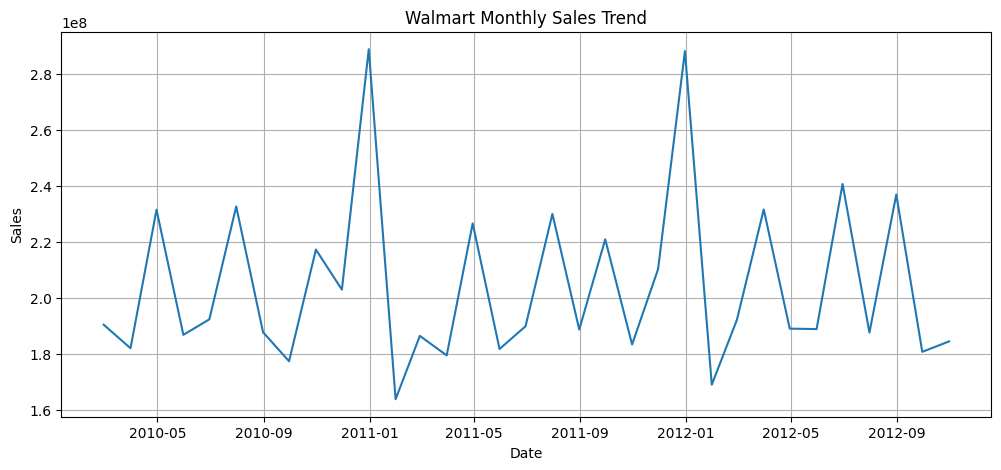

In [18]:
monthly_sales = df.groupby(pd.Grouper(key='Date', freq='M'))['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(12, 5))
plt.plot(monthly_sales['Date'], monthly_sales['Weekly_Sales'])
plt.title("Walmart Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

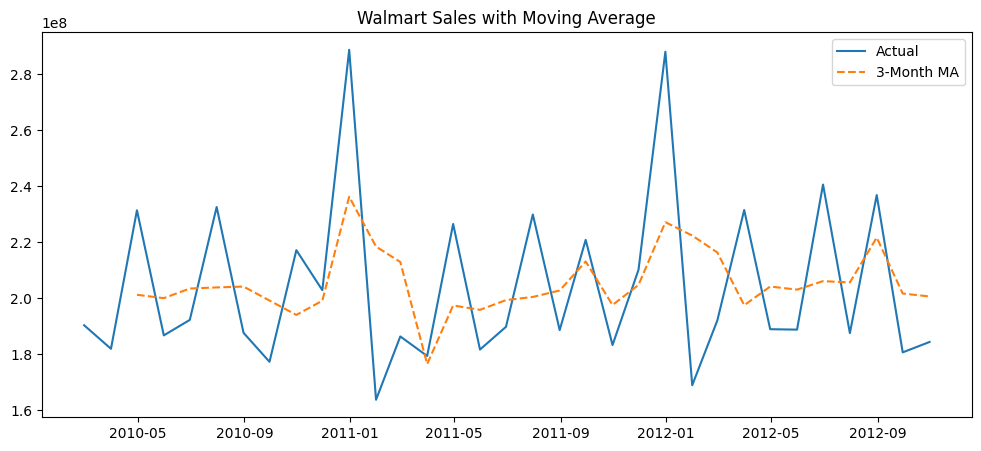

In [19]:
monthly_sales['MA_3'] = monthly_sales['Weekly_Sales'].rolling(window=3).mean()

plt.figure(figsize=(12, 5))
plt.plot(monthly_sales['Date'], monthly_sales['Weekly_Sales'], label='Actual')
plt.plot(monthly_sales['Date'], monthly_sales['MA_3'], label='3-Month MA', linestyle='--')
plt.title("Walmart Sales with Moving Average")
plt.legend()
plt.show()

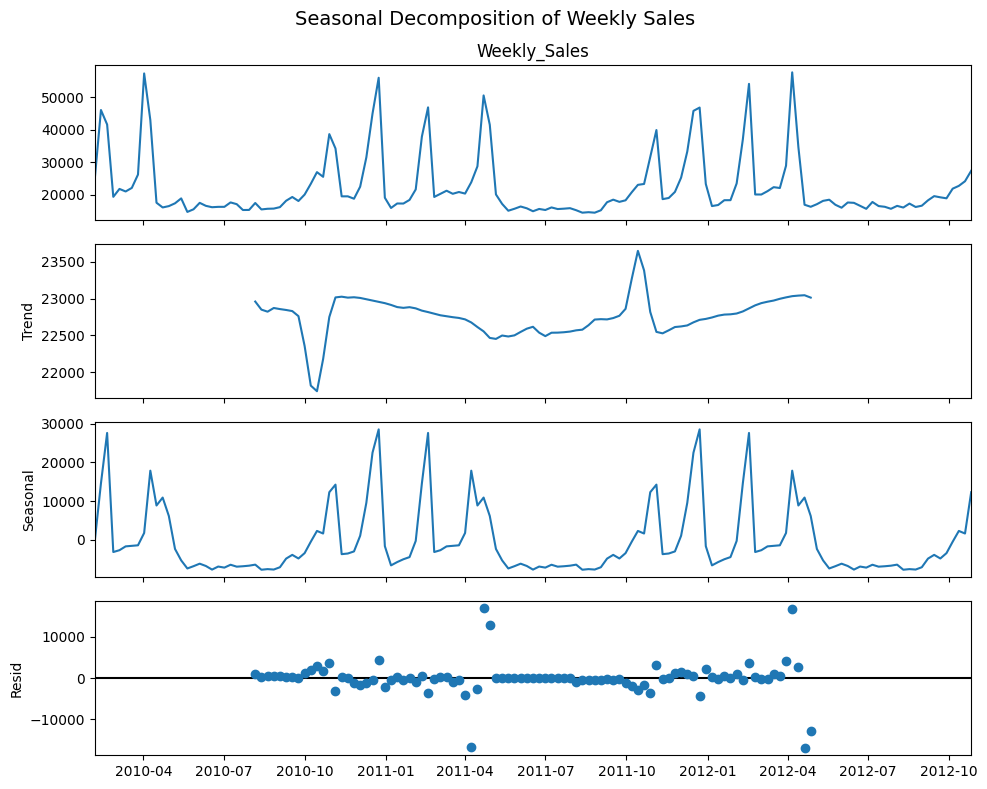

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(ts, model='additive', period=52)
decomp.plot()
plt.gcf().set_size_inches(10, 8)
plt.suptitle('Seasonal Decomposition of Weekly Sales', fontsize=14)
plt.tight_layout()
plt.show()

In [21]:
# Simple forecasting (rolling mean or exponential smoothing)
# 1. Rolling Mean Forecast (Last 3 Months) (uses past average)
monthly_sales['Rolling_Forecast'] = monthly_sales['Weekly_Sales'].rolling(window=3).mean().shift(1)

In [22]:
# 2. Exponential Smoothing Forecast (gives more weight to recent data)
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model = SimpleExpSmoothing(monthly_sales['Weekly_Sales'])
fit = model.fit(smoothing_level=0.6, optimized=False)

monthly_sales['Exp_Smooth'] = fit.fittedvalues

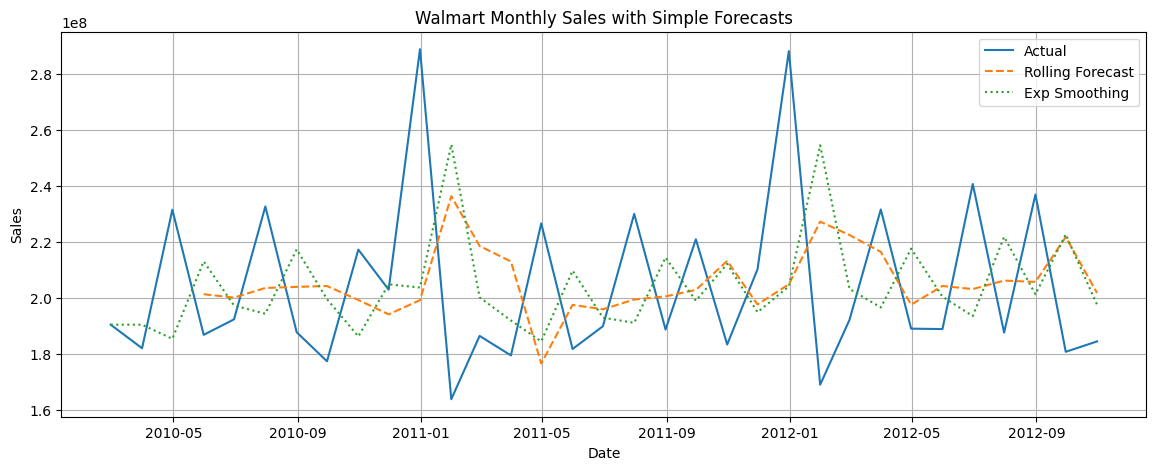

In [23]:
plt.figure(figsize=(14, 5))
plt.plot(monthly_sales['Date'], monthly_sales['Weekly_Sales'], label='Actual')
plt.plot(monthly_sales['Date'], monthly_sales['Rolling_Forecast'], label='Rolling Forecast', linestyle='--')
plt.plot(monthly_sales['Date'], monthly_sales['Exp_Smooth'], label='Exp Smoothing', linestyle=':')
plt.title("Walmart Monthly Sales with Simple Forecasts")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6vq6fci/u0n6y37d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6vq6fci/g6exkhai.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20266', 'data', 'file=/tmp/tmpt6vq6fci/u0n6y37d.json', 'init=/tmp/tmpt6vq6fci/g6exkhai.json', 'output', 'file=/tmp/tmpt6vq6fci/prophet_modelk7gxrfiy/prophet_model-20250804132139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


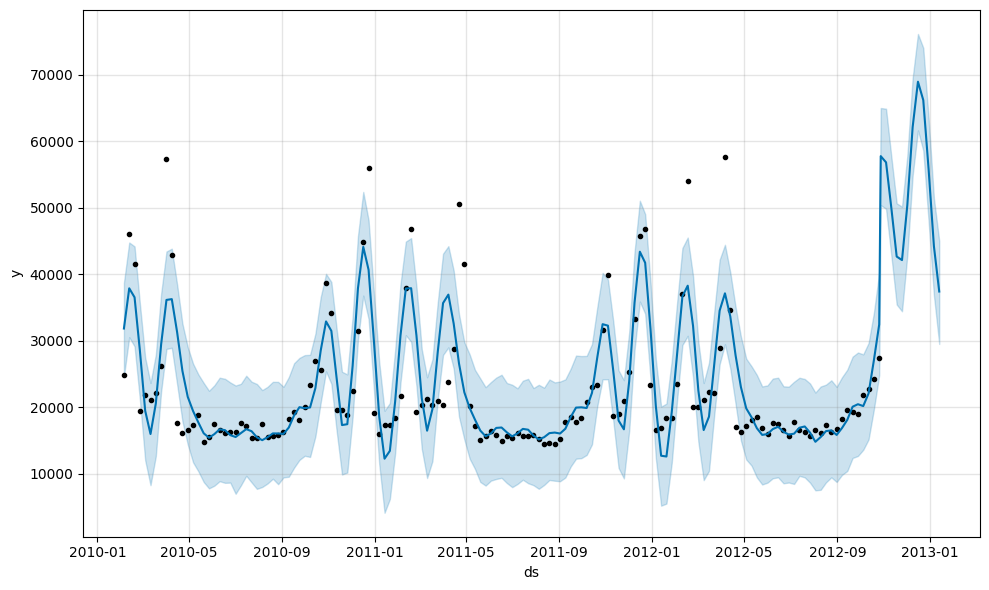

In [24]:
# Forecast Using Prophet with External Regressors (MarkDown, CPI, Unemployment)
from prophet import Prophet

# Prepare data
df = df[(df['Store'] == 1) & (df['Dept'] == 1)]
sales = df[['Date', 'Weekly_Sales', 'MarkDown1', 'CPI', 'Unemployment']].copy()
sales.columns = ['ds', 'y', 'md1', 'cpi', 'unemp']

# Model
m = Prophet(weekly_seasonality=True)
m.add_regressor('md1')
m.add_regressor('cpi')
m.add_regressor('unemp')

m.fit(sales)

# Forecast
future = m.make_future_dataframe(periods=12, freq='W')
future = future.merge(sales[['ds', 'md1', 'cpi', 'unemp']], on='ds', how='left').fillna(0)

forecast = m.predict(future)
fig = m.plot(forecast)
